# **New Jersey Institute of Technology**
# DS 675: Machine Learning, Spring 2023
 
*   Instructor: Dr. Przemyslaw Musialski
*   TA: Haotian Yin
 
# Assignment 2
* Date: 2/7/2023
* **Due: 2/21/2023, 11:59pm EST**
* Total possible points: 40 + 5 bonus points. 
 
 
## Instructions
*   Copy it locally or edit it as a copy in your Google-Colab (File-->Save a Copy in Drive). 
*   Look for notebook cells starting with **"Task #"**. **Edit only in the indicated areas!** Do not forget to write brief documentation for each task in the dedicated cell areas. **Do not edit in other areas!**
*   Delivery Method: Upload a Jupyter notebook following the suggested name convention. 
*   Note: you can access the file only with your NJIT-Google-Account.  Private accounts will not have access. 
*   Submit your solution on CANVAS. Late submissions are penalized with 10% of total points per day. 
 
 
## Academic Policy
A set of ethical principles governing this course:
*   It is okay to share information and knowledge with your 
colleagues, but
*   **It is not okay** to share the code,
*   **It is not okay** to post or give out your code to others (also in the future!),
*   **It is not okay** to use code from others (also from the past) for this Assignment!
 
**Any noticed disregard of these principles will be sanctioned** as per the Academic Integrity Policy of NJIT (http://www5.njit.edu/policies/sites/policies/files/academic-integrity-code.pdf).
 
 
## Late Policy
Late submissions are penalized with 10% of total points per day. Late due is 2/28/2022. No submissions will be accepted after that date. 
 

---
# 1. Setup and Data Processing

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
%matplotlib inline


def data(n_samples = 100, seed = 123, separable = True):
    
    np.random.seed(seed)

    if separable == True: # separable
        # genrate points using Gaussian distributions
        p1 = np.random.multivariate_normal([0, 0], [[1, .95],[.95, 1]], n_samples)
        p2 = np.random.multivariate_normal([1, 4], [[1, .65],[.65, 1]], n_samples)
        X = np.vstack((p1, p2)).astype(np.float32)
        Y = np.hstack((np.ones(n_samples), np.zeros(n_samples)))  

    else: # nonseparable
        p1 = np.random.multivariate_normal([0, 0], [[1, .55],[.55, 1]], n_samples)
        p2 = np.random.multivariate_normal([1, 2.5], [[1, .55],[.55, 1]], n_samples)
        X = np.vstack((p1, p2)).astype(np.float32)
        Y = np.hstack((np.ones(n_samples), np.zeros(n_samples)))  
    return X,Y

---
# 2. Implementation of Learning Algorithms

## Important Functions

In [155]:
# @title Helper Functions

# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# sgn function (step function)
def sgn(z):
    return (z>0.5).astype(float)        # returns {0,1}
    # return 2*(z>0.5).astype(float)-1  # returns {-1,+1}

# X: features, Y: targes, W: weights, Z: scores (net-value)
def log_likelihood(X, Y, W):
    Z = np.dot(X,W)
    LL = np.sum( Y*Z - np.log(1 + np.exp(Z)) )
    return np.sum(LL)

# predict using given model (W) and data point(s) X
def predict(W, X):
    X = np.hstack((np.ones((X.shape[0], 1)), X))                
    Y = sigmoid(np.dot(X,W))
    return (Y>0.5).astype(float), Y

# compute the prediciton accuracy 
# Y_pred are predicted tarets, and Y_true are groundtruth targets
# note, targets are expected to be from the set {0,1} 
def pred_accuracy(Y_pred, Y_true):
    return 1-np.sum(np.square(Y_true-Y_pred))/(Y_true.shape[0])

In [156]:
# @title Ploting Functions

def plot_model_1(W, X, Yc, smooth = True):
    xmin = X[:,0].min()-0.5
    xmax = X[:,0].max()+0.5
    ymin = X[:,1].min()-0.5
    ymax = X[:,1].max()+0.5
    xx, yy = np.mgrid[xmin:xmax:0.01, ymin:ymax:0.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = predict(W, grid) 
    probs = np.array(probs[smooth]).reshape(xx.shape)    
    contour = plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    plt.scatter(X[:, 0], X[:, 1], c=Yc, alpha=.5, s=50, 
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)
    plt.axis([xmin, xmax, ymin, ymax])
    # plt.axis('equal')
    ax = plt.gca()

def plot_model_2(W, X, Yc):
    xmin = X[:,0].min()-0.5
    xmax = X[:,0].max()+0.5
    ymin = X[:,1].min()-0.5
    ymax = X[:,1].max()+0.5
    x1 = np.linspace(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    x2 = -W[1]*x1/W[2]-W[0]/W[2] 
    plt.scatter(X[:, 0], X[:, 1], c = Yc, alpha = .5, cmap="RdBu")
    plt.plot(x1, x2, color='red')
    plt.axis([xmin, xmax, ymin, ymax])
    # plt.axis('equal')
    ax = plt.gca()

---------
## **Task 1**: Logistic Regression (MLE) [**14 points**]

### Implementation [12 points]

Complete the Logistic Regression training function using the Maximum Likelihood Estimation (MLE) approach. In particular, implement the log-likelihood loss gradient descent update rule in the indicated location in the code below. 

Write your code between `--- your code begin --- your code end ---` makrs. 

Implement the following:
*   The update function.
*   The training function stops when no more iterations are necessary.


### Documentation of Task 4 [2 points]
1. Inside the for loop, I'm taking a **dot product of X and W** to find **Z** then calculating predicted probabilites **Y_pred** using the **sigmoid function**.
2. Then I calculated the **gradient** by taking **dot product of X transpose and error (Y - Y_pred)** and updated the weights W.
3. Then I'm checking if the **convergence is less than the threshold**. If it is, the function breaks out of the loop

In [157]:
# Logistic Regression Implementation (MLE)

# input: X are features, Y are targets
# output: W are parameters of the model (weights and bias)
def train_logistic_regression(X, Y, max_iter, learning_rate, print_iter = False):

    # augment the data points with the additional constant 1 to allow for dot-products
    b = np.ones((X.shape[0], 1))
    X = np.hstack((b, X))
        
    # init the model paramerers with zeros
    W = np.zeros(X.shape[1])        
    threshold = 1e-6
        
    # iterate over the set and perform training
    for iteration in range(max_iter): 

        # --- your code begin ---
        Z = np.dot(X,W)
        
        Y_pred = sigmoid(Z)

        gradient = np.dot(X.T, Y - Y_pred)
        
        # Update the model parameters using the gradient and the learning rate
        W = W + learning_rate * gradient
        
        # Check for convergence by computing the change in log-likelihood
        
        if np.linalg.norm(learning_rate * gradient) < threshold:
            break
        

        # --- your code end ---

        if print_iter:
            print("Iteration: ", iteration, "W: ", W)
                
    # output the model parameter vector W
    print("training complete, W =", W, ", iterations:", iteration)
    return W


---------
## **Task 2**: Perceptron [**14 points**]

### Implementation [12 points]

Implement the basic perceptron learning update rule. Use therefore the algorithm as described in the slides, or alternatively, the algorithm described in this notes. In particular implement the iterative perceptron update function.

!Note: the lables (Y) in the data set are given as {0,1}. The rule as described used labels in the set {-1,+1}. Take this into account!

Write your code between `--- your code begin --- your code end ---` marks.

Implement the following:
*   The percepron update function.
*   The training function stops when no more iterations are necessary.


### Documentation of Task 2 [2 points]
1. Inside the for loop, I'm taking a **dot product of X and W** to find **Z** then calculating predicted probabilites **Y_pred** using the **sign function**.
2. Then I calculated the **gradient** by taking **dot product of X and error (Y - Y_pred) and multiplying it with learning_rate** and updated the weights W.
3. Then I'm checking if the **convergence (calculated by checking difference of log likelihood between current and previous iteration) is less than the threshold**. If it is, the function breaks out of the loop

In [158]:
# Perceptron Implementation

# input: X are features, Y are targets
# output: W are parameters of the model (weights and bias)
def train_perceptron(X, Y, max_iter, learning_rate, print_iter = False):
    
    # augment the data points with the additional constant 1 to allow for dot-products
    b = np.ones((X.shape[0], 1))
    X = np.hstack((b, X))
        
    # init the model paramerers with zeros
    W = np.zeros(X.shape[1])       
    threshold = 1e-10

    # iterate over the set and perform training
    for iteration in range(max_iter): 
        
        # --- your code begin ---
        Z = np.dot(X, W)
        Y_pred = sgn(Z)

        # update the model parameters
        gradient =  learning_rate * np.dot((Y - Y_pred), X)
        W = W + gradient
      
        ll_old = log_likelihood(X, Y, W - gradient)
        ll_new = log_likelihood(X, Y, W)
        if np.abs(ll_old - ll_new) < threshold:
            break
        # --- your code end ---

        if print_iter:
            print("Iteration: ", iteration, "W: ", W)

    # output the optimized model parameters
    print("training complete, W =", W, ", iterations:", iteration)
    return W

----------
## **Task 3 (Bonus)**: Perceptron Extensions [**5 points**]

### Implementation [4 points]
Implement extensions to the perceptron algorithm as discussed in the lecture. Experiment with the averaging extension and use it in the comparisons instead of the standard algorithm. 

This task is volunary and will be awarded with 4+1 bonus points (+1 for documentation, see below). 


### Documentation of Task 3 [2 points]
Describ here your solution and how you have done it in 2-3 sentences.

In [159]:
# Perceptron Implementation

# input: X are features, Y are targets
# output: W are parameters of the model (weights and bias)
def train_perceptron(X, Y, max_iter, learning_rate, print_iter = False):
    
    # augment the data points with the additional constant 1 to allow for dot-products
    b = np.ones((X.shape[0], 1))
    X = np.hstack((b, X))
        
    # init the model paramerers with zeros
    W = np.zeros(X.shape[1])       
    threshold = 1e-10

    # iterate over the set and perform training
    for iteration in range(max_iter): 
        
        # --- your code begin ---
        Z = np.dot(X, W)
        Y_pred = sgn(Z)

        # update the model parameters
        gradient =  learning_rate * np.dot((Y - Y_pred), X)
        W = W + gradient
      
        ll_old = log_likelihood(X, Y, W - gradient)
        ll_new = log_likelihood(X, Y, W)
        if np.abs(ll_old - ll_new) < threshold:
            break
        # --- your code end ---

        if print_iter:
            print("Iteration: ", iteration, "W: ", W)

    # output the optimized model parameters
    print("training complete, W =", W, ", iterations:", iteration)
    return W

---
# 3. Training and Testing of the Models

## **Task 4**: Training of Both Methods [**6 points**]

### Implementation [5 points]

The code below calls the training functions which you should have completed above. Perform the training and try to find the best set of hyperparameters (max_iteratons, learning_rate), such that the accuracy on the test set is best. 


### Documentation of Task 4 [2 points]
I tried multiple tests for different values of max_iter and learning rate and the best values I could find for logistic regression are **max_iter = 1000** and **learning_rate = 0.001**, and for perceptron are **max_iter = 1000** and **learning_rate = 0.5**

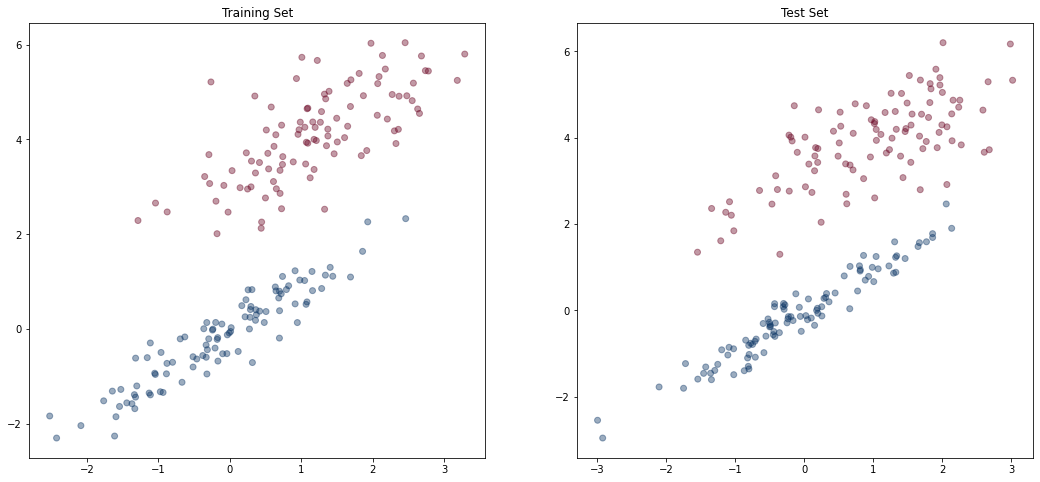

In [160]:
# @title Create and Plot Datasets

X_train, Y_train = data(n_samples = 100, seed = 123, separable = True)
X_test,  Y_test  = data(n_samples = 100, seed = 321, separable = True)

plt.subplots(figsize=(18, 8))
plt.subplot(1,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c = Y_train, alpha = .4, cmap="RdBu")
plt.title("Training Set")
plt.subplot(1,2,2)
plt.scatter(X_test[:, 0],  X_test[:, 1],  c = Y_test,  alpha = .4, cmap="RdBu")
plt.title("Test Set")
plt.show()

In [161]:
# train logistic regression
W_logr = train_logistic_regression(X_train, Y_train, max_iter = 1000, learning_rate=0.001)
# train perceptron
W_perc = train_perceptron(X_train, Y_train, max_iter = 1000, learning_rate=0.5)

training complete, W = [ 4.44049266  1.96684998 -3.25257918] , iterations: 999
training complete, W = [ 96.5         44.63000679 -80.06042342] , iterations: 15


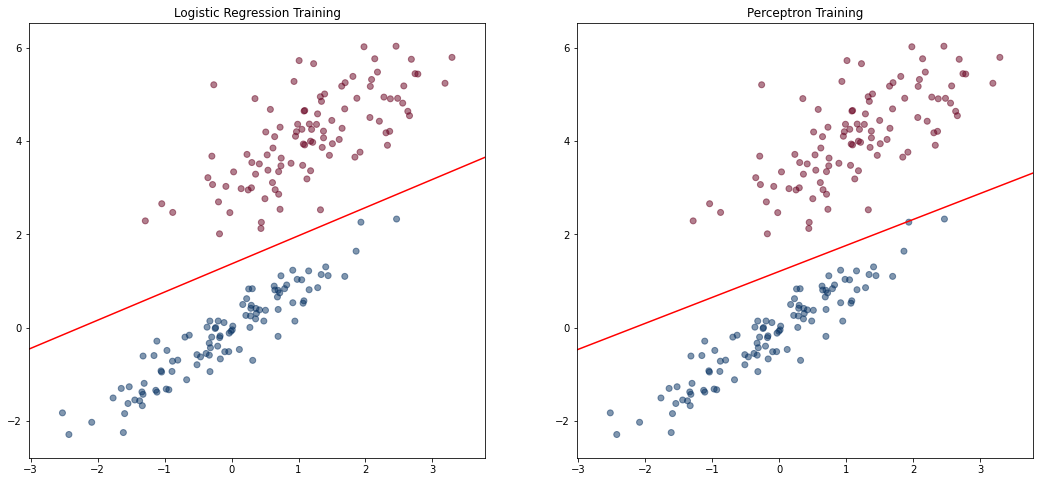

In [162]:
# @title Plot the trained models using the training sets

plt.subplots(figsize=(18, 8))
plt.subplot(1,2,1)
plot_model_2(W_logr, X_train, Y_train)
plt.title("Logistic Regression Training")
plt.subplot(1,2,2)
plot_model_2(W_perc, X_train, Y_train)
plt.title("Perceptron Training")

plt.show()



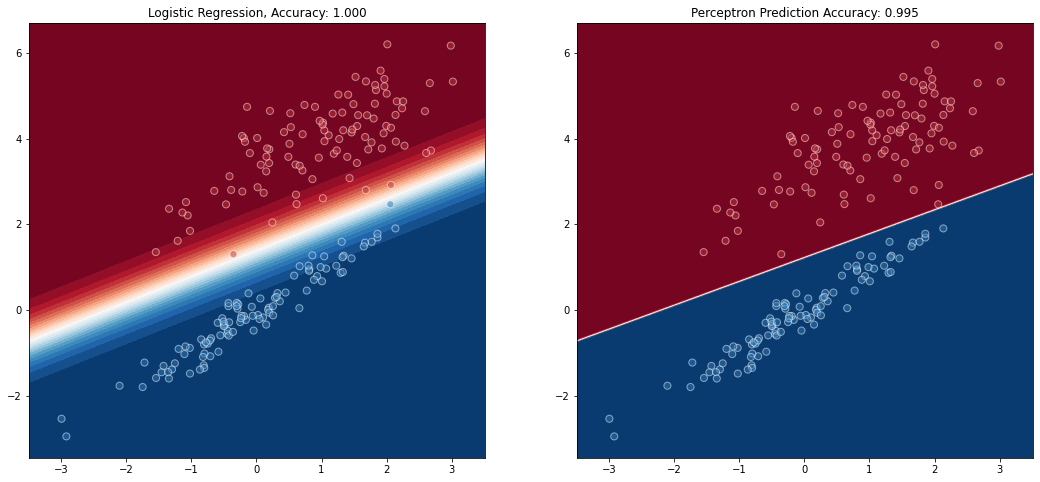

In [163]:
# @title Prediction of Logistic Regression using Test Data

Y_pred, Y_smooth = predict(W_logr, X_test)

plt.subplots(figsize=(18, 8))
plt.subplot(1,2,1)
plot_model_1(W_logr, X_test, Y_pred)
plt.title("Logistic Regression, Accuracy: %1.3f" %pred_accuracy(Y_test, Y_pred))

Y_pred, Y_smooth = predict(W_perc, X_test)

plt.subplot(1,2,2)
plot_model_1(W_perc, X_test, Y_pred)
plt.title("Perceptron Prediction Accuracy: %1.3f" %pred_accuracy(Y_test, Y_pred))
plt.show()

---
# 4. Train and Compare to SCI-KIT LEARN
https://scikit-learn.org/stable/

Sci-kit Learn is a Python framework for machine learning. We will use it in future assignments, please get familiar with it. 

This example below shows how to use the simple models we have implemented above. 

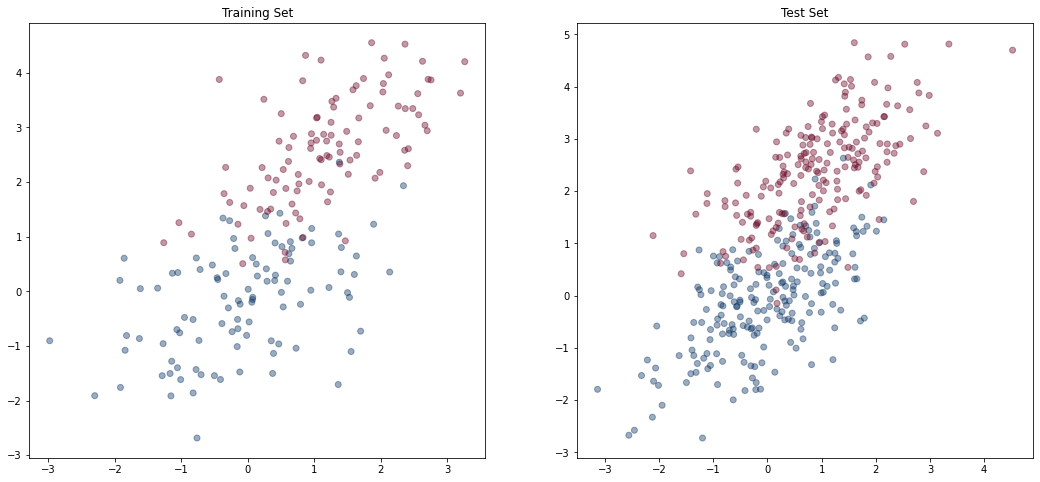

In [164]:
# @title Create and Plot Overlapping Datasets

X_train, Y_train = data(n_samples = 100, seed = 123, separable = False)
X_test,  Y_test  = data(n_samples = 200, seed = 321, separable = False)

plt.subplots(figsize=(18, 8))
plt.subplot(1,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c = Y_train, alpha = .4, cmap="RdBu")
plt.title("Training Set")
plt.subplot(1,2,2)
plt.scatter(X_test[:, 0],  X_test[:, 1],  c = Y_test,  alpha = .4, cmap="RdBu")
plt.title("Test Set")
plt.show()

## **Task 5**: Experiment with Hyperparameters [**6 points**]

### Implementation [4 points]

Find a set of hyperparameters such that both classifiers perform as best as possible on the non-separable dataset. Note, that this data set is not linearly separable, so do not expect 100% accuracy, however, try to achieve similar results as the Scikit-Learn implementation below.

### Document Task 5 [2 points]
I tried multiple tests for different values of max_iter and learning rate and the best values I could find for logistic regression are **max_iter = 500** and **learning_rate = 0.46**, and for perceptron are **max_iter = 1000** and **learning_rate = 0.08**,

In [165]:
# train logistic regression
W_logr = train_logistic_regression(X_train, Y_train, max_iter=500, learning_rate=0.46)

# train perceptron
W_perc = train_perceptron(X_train, Y_train, max_iter=1000, learning_rate=0.08)

training complete, W = [ 6.77620882  1.29716053 -6.00668703] , iterations: 499
training complete, W = [ 2.96        0.54788679 -2.05496509] , iterations: 999


<ipython-input-155-4bc4478d9032>:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


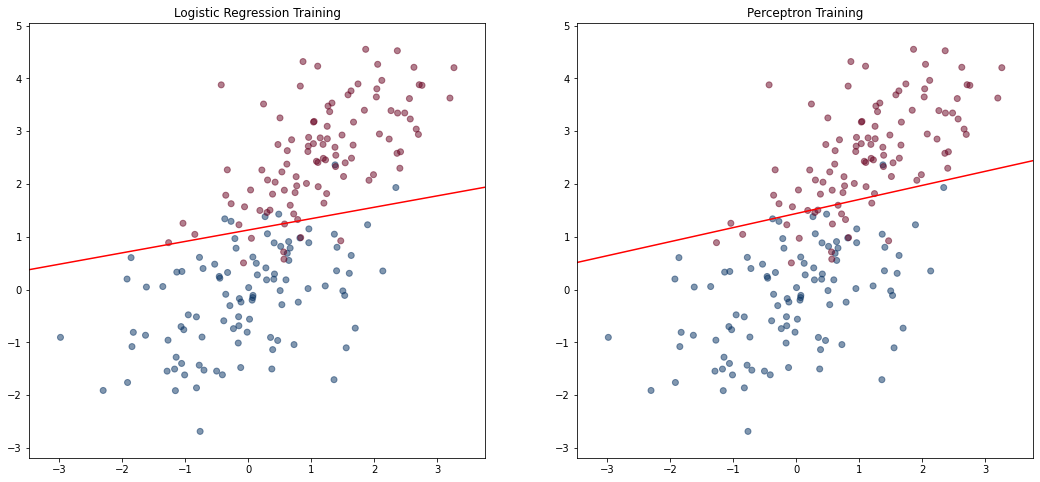

In [166]:
# @title Plot the trained models using the training sets

plt.subplots(figsize=(18, 8))
plt.subplot(1,2,1)
plot_model_2(W_logr, X_train, Y_train)
plt.title("Logistic Regression Training")
plt.subplot(1,2,2)
plot_model_2(W_perc, X_train, Y_train)
plt.title("Perceptron Training")
plt.show()

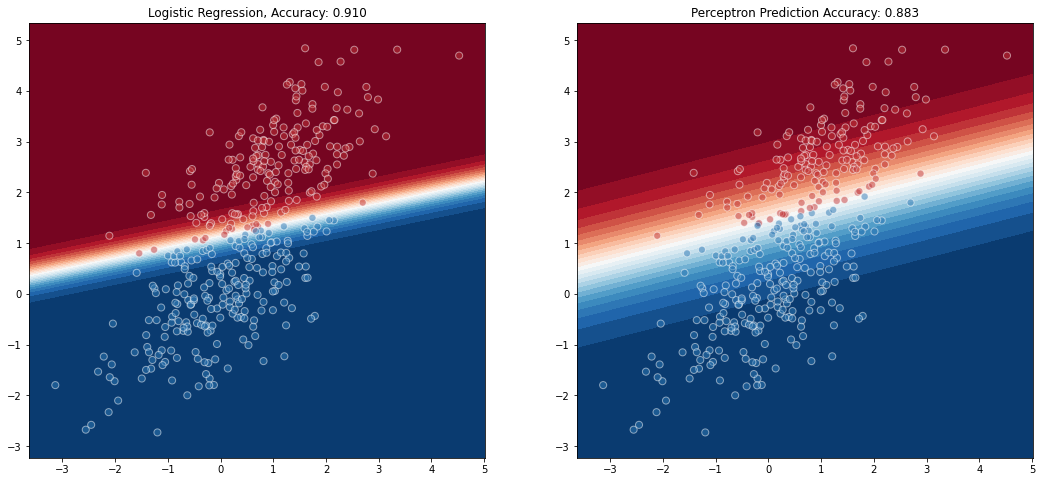

In [167]:
# @title Prediction of Logistic Regression using Test Data

Y_pred, Y_smooth = predict(W_logr, X_test)

plt.subplots(figsize=(18, 8))
plt.subplot(1,2,1)
plot_model_1(W_logr, X_test, Y_pred)
plt.title("Logistic Regression, Accuracy: %1.3f" %pred_accuracy(Y_test, Y_pred))

Y_pred, Y_smooth = predict(W_perc, X_test)

plt.subplot(1,2,2)
plot_model_1(W_perc, X_test, Y_pred)
plt.title("Perceptron Prediction Accuracy: %1.3f" %pred_accuracy(Y_test, Y_pred))
plt.show()

Below training and testing using models from the sci-kit learn toolkit

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
model1 = LogisticRegression()
model2 = Perceptron()

model1.fit(X_train, Y_train)
Y_logr_sck = model1.predict(X_test)
accuracy_logr_sck = accuracy_score(Y_test.flatten(), Y_logr_sck)
print('Logistic regression accuracy: ', accuracy_logr_sck)
print('Confusion matrix:\n', confusion_matrix(Y_test.flatten(), Y_logr_sck))
W_logr_sck = np.insert(model1.coef_[0], 0, model1.intercept_[0])

model2.fit(X_train, Y_train)
Y_perc_sck = model2.predict(X_test)
accuracy_perc_sck = accuracy_score(Y_test.flatten(), Y_perc_sck)
print('Percepton accuracy: ', accuracy_perc_sck)
print('Confusion matrix:\n', confusion_matrix(Y_test.flatten(), Y_perc_sck))
W_perc_sck = np.insert(model2.coef_[0], 0, model2.intercept_[0])


Logistic regression accuracy:  0.905
Confusion matrix:
 [[176  24]
 [ 14 186]]
Percepton accuracy:  0.865
Confusion matrix:
 [[149  51]
 [  3 197]]


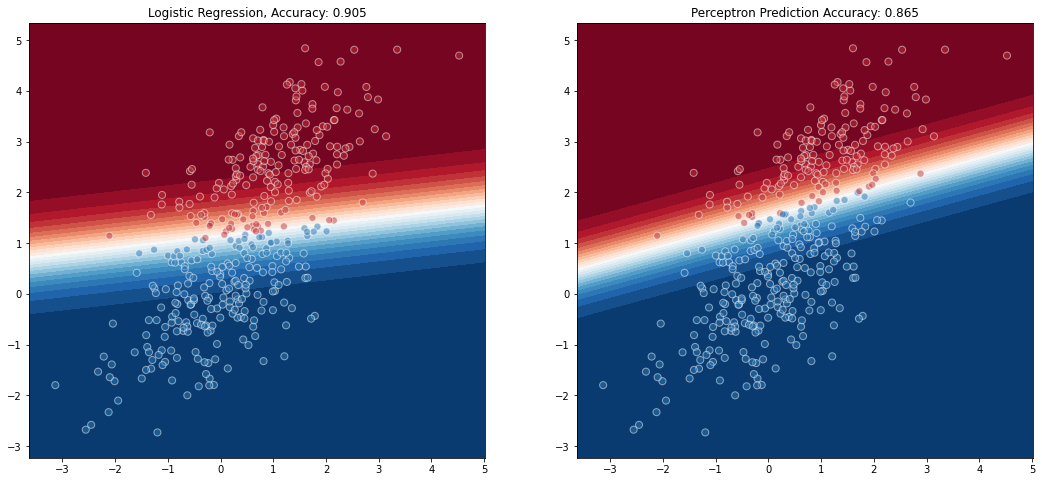

In [169]:
# @title Prediction on Test Data given by Sci-Kit Learn models

Y_pred, Y_smooth = predict(W_logr_sck, X_test)

plt.subplots(figsize=(18, 8))
plt.subplot(1,2,1)
plot_model_1(W_logr_sck, X_test, Y_logr_sck)
plt.title("Logistic Regression, Accuracy: %1.3f" %pred_accuracy(Y_test, Y_logr_sck))

Y_pred, Y_smooth = predict(W_perc_sck, X_test)

plt.subplot(1,2,2)
plot_model_1(W_perc_sck, X_test, Y_perc_sck)
plt.title("Perceptron Prediction Accuracy: %1.3f" %pred_accuracy(Y_test, Y_perc_sck))
plt.show()